In [41]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy import signal
import numpy.random as rnd
import pandas as pd
import h5py

plt.rcParams["figure.figsize"] = (10,8)

# Lab 4

## Problem 1
In this problem we are looking at the data from a gamma-ray satellite orbiting in low Earth orbit. It takes a reading of the number of particles detected every 100 milliseconds, and is in an approximately 90 minute orbit. While it is looking for gamma-ray bursts, virtually all of the particles detected are background cosmic rays.

As with most data, there are 'features.' Your lab instructor has helpfully incorporated the meta-data into your data file.

1) Down load the data from the course website (gammaray_lab4.h5), and import it into your working environment. The data has 4 columns and more than 25 million rows. The columns are time (in gps seconds), Solar phase (deg) showing the position of the sun relative to the orbit, Earth longitude (deg) giving the position of the spacecraft relative to the ground, and particle counts. Make a few plots, generally exploring your data and making sure you understand it. Give a high level description of the data features you see. Specifically comment on whether you see signal contamination in your data, and how you plan to build a background pdf().

2) The background is not consistent across the dataset. Find and describe as accurately as you can how the background changes.

3) Create a model for the background that includes time dependence, and explicitly compare your model to the data. How good is your model of the background?

4) Because the background varies, your discovery sensitivity threshold (how many particles you would need to see) also varies. What is the '5-sigma' threshold for a 100 millisecond GRB at different times? 

In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')
data = np.array(hf.get('data'))
data = np.transpose(data)
hf.close()
#df.to_csv('gammarayh5.csv')

In [3]:
df = pd.DataFrame(data, columns=['time (gps-seconds)', 'solar phase (deg)', 'Earth longitude (deg)', 'particle counts'])
df

,time (gps-seconds),solar phase (deg),Earth longitude (deg),particle counts
0,940680016.0,315.000000,45.000000,10.0
1,940680016.1,315.007112,45.006667,8.0
2,940680016.2,315.014225,45.013333,7.0
3,940680016.3,315.021337,45.020000,11.0
4,940680016.4,315.028449,45.026667,8.0
...,...,...,...,...
25919996,943272015.6,345.304884,44.973333,5.0
25919997,943272015.7,345.311996,44.980000,9.0
25919998,943272015.8,345.319109,44.986667,8.0
25919999,943272015.9,345.326221,44.993333,11.0


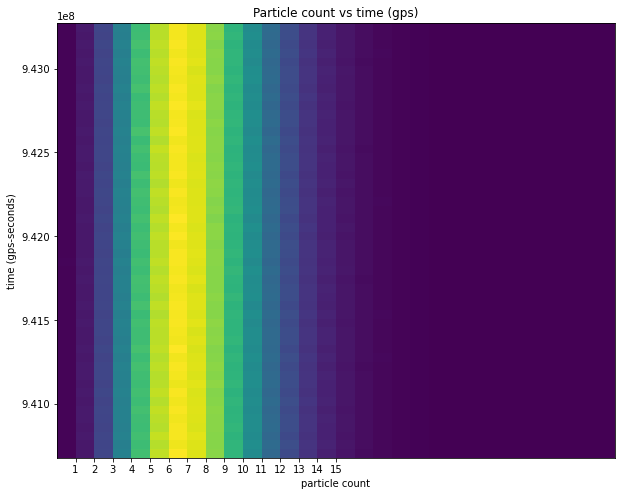

In [4]:
plt.hist2d(df['particle counts'], df['time (gps-seconds)'], bins = [30, 50])
plt.title('Particle count vs time (gps)')
plt.xlabel('particle count')
plt.ylabel('time (gps-seconds)')
plt.xticks(np.arange(1, 16))
plt.show()

From the 2D histogram, our peak (mu) of particle counts is between 6 and 7. We should use a Poisson distribution of particle counts because the events should be discrete and time-independent. This particle count vs time histogram has variances, which can be seen by small amounts of discoloration within the bins.

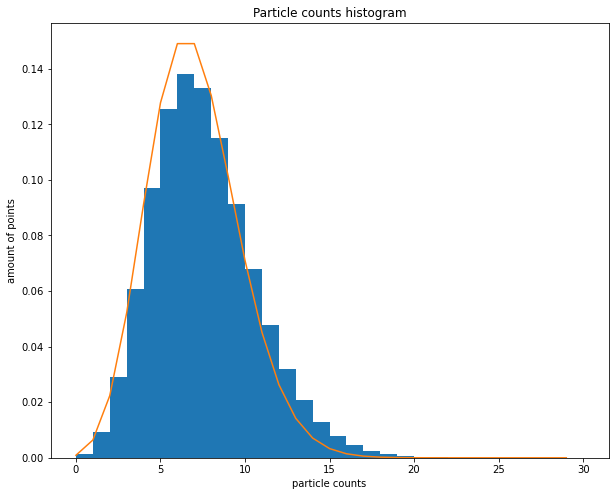

In [5]:
plt.hist(df['particle counts'], density=True, bins = 30)
mu = 6.5
#x = np.linspace()
x = np.arange(0, 30, 1)
poiss = stats.poisson.pmf(x, mu=7)
plt.plot(x, poiss)
plt.title('Particle counts histogram')
plt.xlabel('particle counts')
plt.ylabel('amount of points')
plt.show()

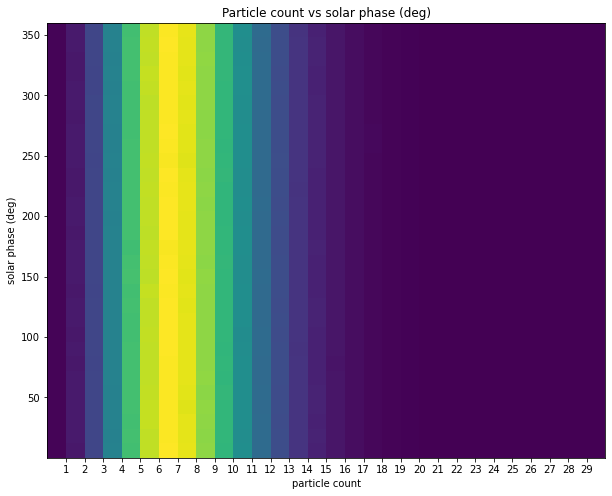

In [6]:
plt.hist2d(df['particle counts'], df['solar phase (deg)'], bins = 30)
plt.title('Particle count vs solar phase (deg)')
plt.xlabel('particle count')
plt.ylabel('solar phase (deg)')
plt.xticks(np.arange(1, 30))
plt.show()

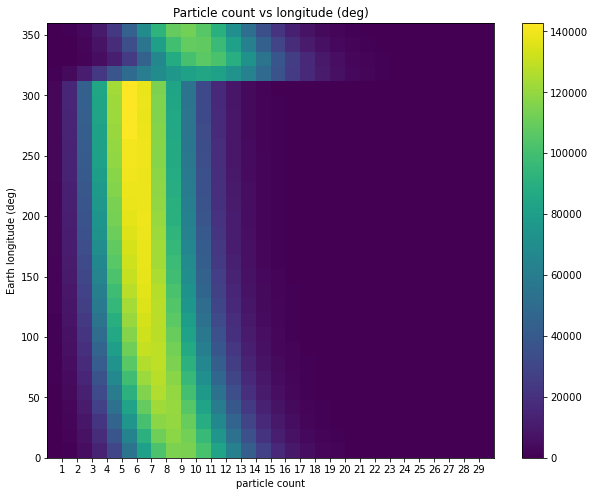

In [7]:
plt.hist2d(df['particle counts'], df['Earth longitude (deg)'], bins = 30)
plt.title('Particle count vs longitude (deg)')
plt.xlabel('particle count')
plt.ylabel('Earth longitude (deg)')
plt.xticks(np.arange(1, 30))
plt.colorbar()
plt.show()

2.) The particle counts seem independent of time and solar phase, but is dependent on the Earth longitude, or the position of the satellite, as the particle count starts to increase at around 100 degrees, and as it moves down and loops around >300, the particle count increases to as much as 20-21 particles.

3) Create a model for the background that includes time dependence, and explicitly compare your model to the data. How good is your model of the background?

Our background is cyclic and sinusoidal as the satellite orbits around the Earth every ninety minutes. In order to include time dependence, we should fold our time and particle count by taking the modulo of the time column by 2 pi.

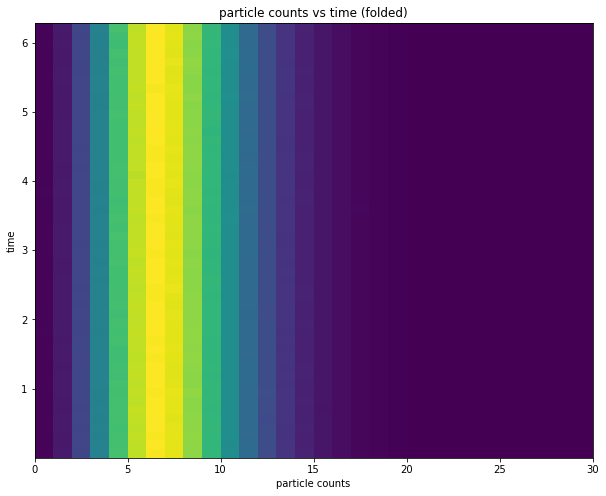

In [8]:
df['time_fold'] = df['time (gps-seconds)'] % (2*np.pi)
#df['particle_fold'] = df['particle counts'] % (2*np.pi)
#t_fold = t % (2*np.pi)
#bkgd_fold = bkgd % (2*np.pi)
plt.hist2d(df['particle counts'], df['time_fold'], bins = [30, 50])
plt.xlabel('particle counts')
plt.ylabel('time')
plt.title('particle counts vs time (folded)')
plt.show()

A side-by-side comparison:

Text(0, 0.5, 'time (gps-seconds)')

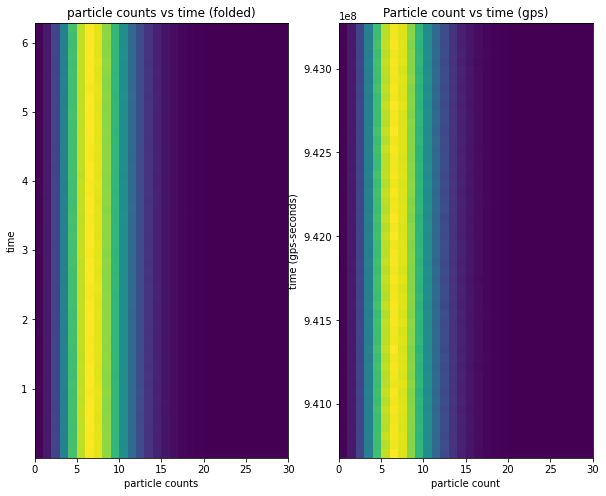

In [9]:
fig, ax = plt.subplots(1,2)

ax[0].hist2d(df['particle counts'], df['time_fold'], bins = [30, 50])
ax[0].set_xlabel('particle counts')
ax[0].set_ylabel('time')
ax[0].set_title('particle counts vs time (folded)')

ax[1].hist2d(df['particle counts'], df['time (gps-seconds)'], bins = [30, 50])
ax[1].set_title('Particle count vs time (gps)')
ax[1].set_xlabel('particle count')
ax[1].set_ylabel('time (gps-seconds)')

The time dependent model is better than our original model because there seems to be less variance within the particle count bands - there is less discoloration when time is folded.

The five-sigma threshold for a 100 ms GRB at any time can be found by taking the average of 100 ms bursts in a given minute. We can do this by convoluting by the amount of bursts per minute.

In [10]:
x = np.arange(0, 30, 1)
poiss = stats.poisson.pmf(x, mu=7)

In [11]:
def convoluter (n, dist, mu):
    conv_last = dist
    for i in range(n):
        conv_new = signal.convolve(conv_last, dist)
        conv_last = conv_new
        #print('convolution' + str(i+1))

    x_new = np.linspace(stats.poisson.ppf(0.01, mu), stats.poisson.ppf(0.99, mu), np.size(conv_new))
    
    return conv_new, x_new

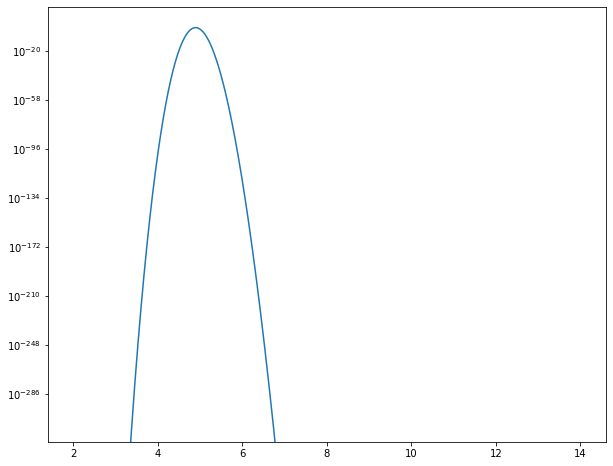

In [12]:
nconv = 10 * 60 # 10 bursts per second, 60 seconds per minute, 90 minutes
poiss_conv, x_conv = convoluter(nconv, poiss, 7)
#poiss_conv = poiss_conv * 10e20
plt.yscale('log')
plt.plot(x_conv, poiss_conv)
plt.show()

In [13]:
val = poiss_conv[round(np.median(np.where((x_conv > 4) & (x_conv < 6))))]
val

0.0004300475001617415

In [14]:
five_sig = 1/3.5e6
particles = stats.poisson.isf(1/3.5e6, 7)
particles

24.0

The five sigma threshold for a 100 ms burst at any time is 24 particles.

## Problem 2
In this problem we are going to look at a stack of telescope images (again simulated). We have 10 images, but you and your lab partner will be looking for different signals. One of you will be looking for the faintest stars, while the other will be looking for a transient (something like a super novae that only appears in one image). Flip a coin to determine which of you is pursuing which question.

1) Dowload the data from images.h5. This is a stack of 10 square images, each 200 pixels on a side.

2) Explore the data. Is there signal contamination? Is the background time dependent? Is it consistent spatially? Develop a plan to calculate your background pdf().

3) Using your background distribution, hunt for your signal (faint stars). Describe what you find.

4) You and your lab partner had different pdf(), but were using the same data. Explore why this is.

In [101]:
hfi = h5py.File('images.h5', 'r')
hfi.keys()

<KeysViewHDF5 ['image1', 'imagestack']>

In [102]:
data_imstack = np.array(hfi.get('imagestack'))
data_imstack = np.transpose(data_imstack)
data_im1 = np.array(hfi.get('image1'))
data_im1 = np.transpose(data_im1)
hfi.close()

In [110]:
def imsub (base, stack, n):
    sub = 0
    for i in range(n):
        sub -= stack[i]
        base -= sub
    plt.imshow(base)
    plt.colorbar()
    plt.show()

In [121]:
def imsubind (base, stack, n):
    #sub = 0
    #for i in range(n):
    #    sub -= stack[i]
    #    base -= sub
    plt.imshow(base-stack[n])
    plt.colorbar()
    plt.show()

In [37]:
def imsuball (base, stack, n):
    sub = 0
    images = []
    for i in range(n):
        sub -= stack[i]
        im = base - sub
        images.append(im)
    fig, ax = plt.subplots(1,n, figsize=(10,7))
    fig.tight_layout()
    for i in range(n):
        ax[i].imshow(images[i])

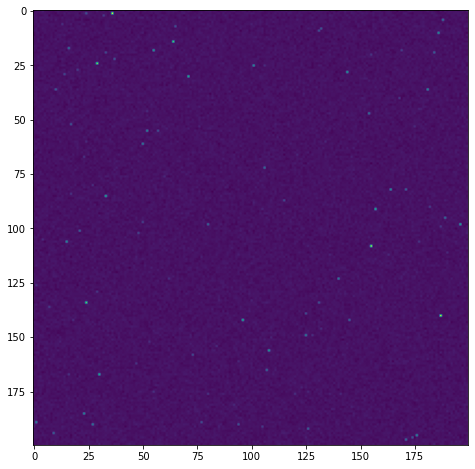

In [111]:
plt.imshow(data_im1)

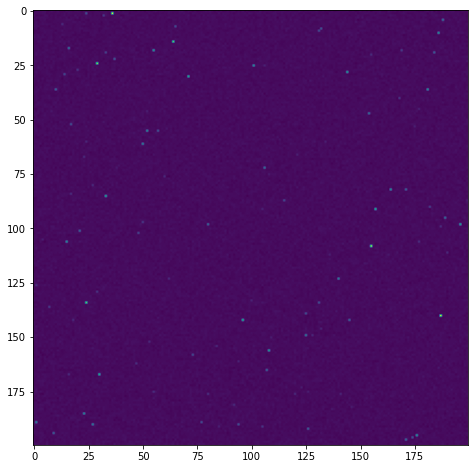

In [60]:
imsub(data_im1, data_imstack, 2)

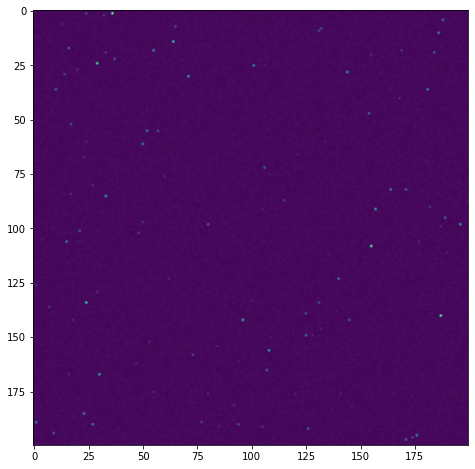

In [61]:
imsub(data_im1, data_imstack, 5)

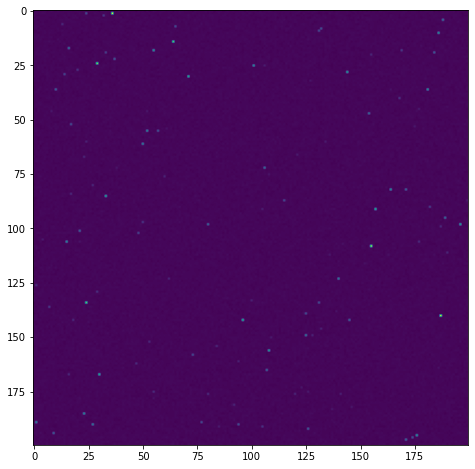

In [62]:
imsub(data_im1, data_imstack, 10)

There is signal contamination from other light sources, but those can be filtered out by taking our base image and subtracting our image stack from the base. From here we can clearly pick out bright stars, and faint stars that have made it through filtering. We can possibly take in more fainter stars by subtracting less images, thus increasing our threshold. We can get our background distribution by taking our two images from the stack and subtracting them from each other, and then taking a histogram of the first axis.

In [105]:
#im_dist = (data_im1 - data_imstack[0])
#im_dist = imsubret(data_im1, data_imstack, 10)
im_dist = data_imstack[0] - data_imstack[1]

Text(0, 0.5, 'pixel count')

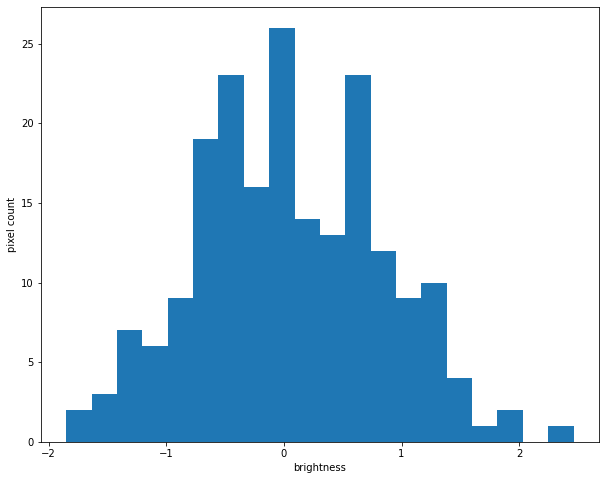

In [120]:
plt.hist(im_dist[0], bins = 20)
plt.xlabel('brightness')
plt.ylabel('pixel count')

Using this background distribution, I can hunt for faint stars by filtering out background noise through subtracting images from the base.

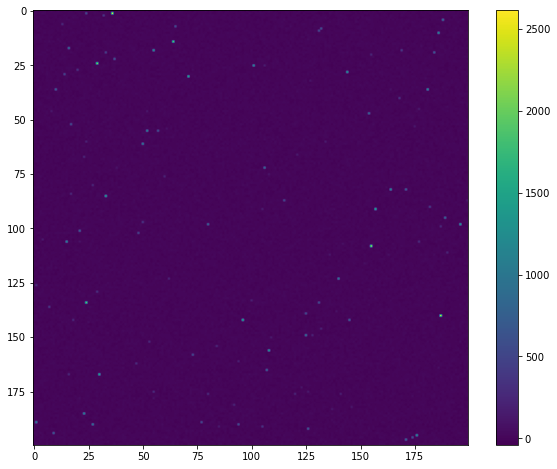

In [122]:
imsub(data_im1, data_imstack, 10)

Faint stars can be found by consulting the colorbar and finding signals that have a low brightness count.

My partner probably had different pdf()s because the distribution probably differs slightly from image to image.